## 0. SETTING

In [1]:
!pip install sentencepiece

In [2]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# vocab loading
vocab_file = './kowiki.model'
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

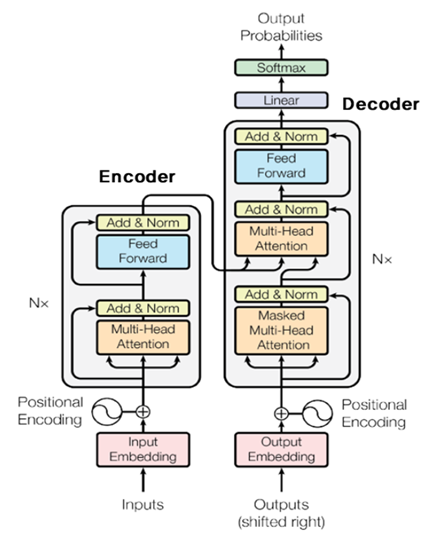

## 1. Vocab 및 Encoder 입력

In [111]:
# 입력 texts
lines = [
  "겨울은 추워요",
  "겨울에는 집에만 있어요"
]

# text를 tensor로 변환
inputs = []
for line in lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    inputs.append(torch.tensor(ids))
    print(pieces)

# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# 값
print(inputs)

['▁겨울', '은', '▁추', '워', '요']
['▁겨울', '에는', '▁집', '에', '만', '▁있어', '요']
torch.Size([2, 7])
tensor([[3091, 3604,  206, 3958, 3760,    0,    0],
        [3091,   64,  313, 3591, 3665,  516, 3760]])


### Input Embedding

In [120]:
n_vocab = len(vocab) # vocab count 8007
d_hidn = 512 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding 객체

input_embs = nn_emb(inputs) # input embedding
print(input_embs.size())

torch.Size([2, 7, 512])


In [121]:
input_embs

tensor([[[-2.0356,  0.8734,  2.7551,  ..., -1.0938,  0.9827, -1.2583],
         [-1.0099, -0.1681, -0.8904,  ..., -1.7753, -0.0962, -0.2915],
         [-0.8935,  0.6617,  0.2162,  ...,  0.2807, -0.3502,  1.6413],
         ...,
         [-1.3425,  0.9839,  2.5216,  ...,  2.1304,  0.1174, -1.2650],
         [ 0.7566, -0.9478, -0.8600,  ...,  0.7592,  1.1731, -0.4213],
         [ 0.7566, -0.9478, -0.8600,  ...,  0.7592,  1.1731, -0.4213]],

        [[-2.0356,  0.8734,  2.7551,  ..., -1.0938,  0.9827, -1.2583],
         [ 1.0456, -0.6305, -1.0290,  ..., -0.8937,  0.0803, -0.1498],
         [ 0.0172,  2.0626, -1.3349,  ...,  1.7193,  1.0951,  0.7274],
         ...,
         [ 0.1161, -0.1027,  0.6384,  ..., -0.5263,  0.0755, -0.8117],
         [ 0.0185,  0.6965, -1.0903,  ...,  0.3135, -0.0055, -2.0997],
         [-1.3425,  0.9839,  2.5216,  ...,  2.1304,  0.1174, -1.2650]]],
       grad_fn=<EmbeddingBackward>)

### Position Embedding

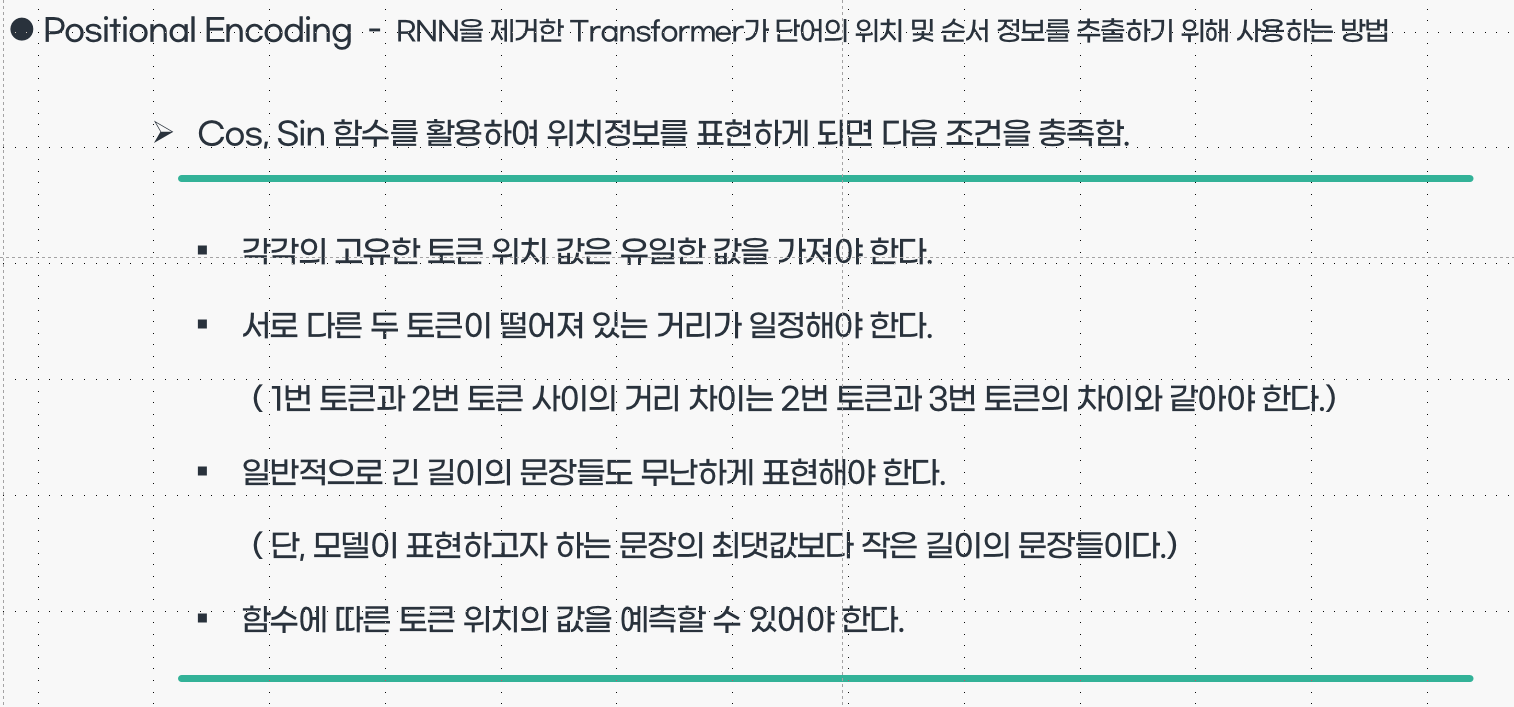

In [122]:
""" sinusoid position embedding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return sinusoid_table

(512, 512)


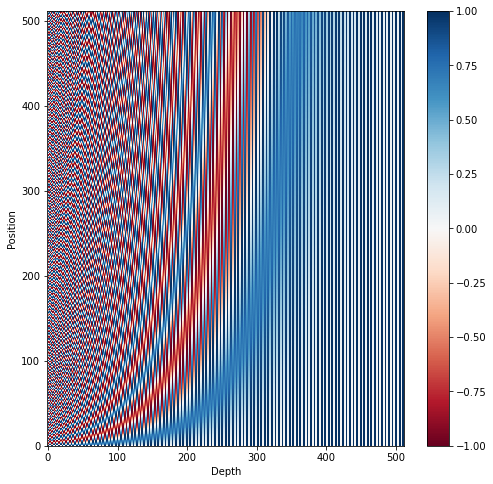

In [123]:
n_seq = 512
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print (pos_encoding.shape) # 크기 출력
plt.figure(figsize=(8,8))
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((-1, d_hidn))
plt.ylabel('Position')
plt.colorbar()

plt.show()

In [124]:
pos_encoding[511]

array([ 0.8817704 , -0.47167887,  0.2839957 , -0.95882555, -0.90939294,
       -0.41593808,  0.04558146,  0.99896063,  0.44107391, -0.89747078,
       -0.37680015,  0.92629458, -0.23451568, -0.97211234,  0.98421037,
        0.1770027 , -0.07828259,  0.99693121, -0.8691673 ,  0.49451815,
       -0.99978653,  0.02066121, -0.99989733, -0.01432966, -0.92261562,
        0.38572064, -0.32868742,  0.94443877,  0.79522305,  0.606317  ,
        0.53809709, -0.84288287, -0.99507275, -0.09914747,  0.67543421,
        0.73742025, -0.36205549, -0.93215654,  0.33872412,  0.94088574,
       -0.60883065, -0.79330022,  0.95964774,  0.28120492, -0.79191117,
        0.6106363 , -0.32191505, -0.94676856,  0.95886597, -0.2838592 ,
        0.50280407,  0.86440041, -0.51055761,  0.85984355, -0.97323584,
        0.22980863, -0.94898855, -0.31531053, -0.80691796, -0.59066353,
       -0.75839664, -0.65179332, -0.84554237, -0.53390833, -0.98013938,
       -0.19830985, -0.9311877 ,  0.36454007, -0.41057873,  0.91

In [125]:
pos_encoding = torch.FloatTensor(pos_encoding) 
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True) # 학습되는 값이 아니다. 

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print(inputs)#입력 문장
print(positions)# 입력 문장에 대한 위치 정보
print(pos_embs.size())# 포지션 임베딩 사이즈

tensor([[3091, 3604,  206, 3958, 3760,    0,    0],
        [3091,   64,  313, 3591, 3665,  516, 3760]])
tensor([[1, 2, 3, 4, 5, 0, 0],
        [1, 2, 3, 4, 5, 6, 7]])
torch.Size([2, 7, 512])


In [126]:
input_sums = input_embs + pos_embs

In [127]:
input_sums.size()

torch.Size([2, 7, 512])

In [128]:
input_sums

tensor([[[-1.1941,  1.4137,  3.5769,  ..., -0.0938,  0.9828, -0.2583],
         [-0.1006, -0.5842,  0.0460,  ..., -0.7753, -0.0960,  0.7085],
         [-0.7524, -0.3283,  0.4613,  ...,  1.2807, -0.3499,  2.6413],
         ...,
         [-2.3014,  1.2676,  1.5278,  ...,  3.1304,  0.1179, -0.2650],
         [ 0.7566,  0.0522, -0.8600,  ...,  1.7592,  1.1731,  0.5787],
         [ 0.7566,  0.0522, -0.8600,  ...,  1.7592,  1.1731,  0.5787]],

        [[-1.1941,  1.4137,  3.5769,  ..., -0.0938,  0.9828, -0.2583],
         [ 1.9549, -1.0466, -0.0926,  ...,  0.1063,  0.0805,  0.8502],
         [ 0.1583,  1.0726, -1.0898,  ...,  2.7193,  1.0954,  1.7274],
         ...,
         [-0.8429,  0.1810, -0.3555,  ...,  0.4737,  0.0760,  0.1883],
         [-0.2610,  1.6567, -1.5655,  ...,  1.3135, -0.0049, -1.0997],
         [-0.6855,  1.7378,  2.9740,  ...,  3.1304,  0.1181, -0.2650]]],
       grad_fn=<AddBackward0>)

### 2. Scale Dot Product Attention
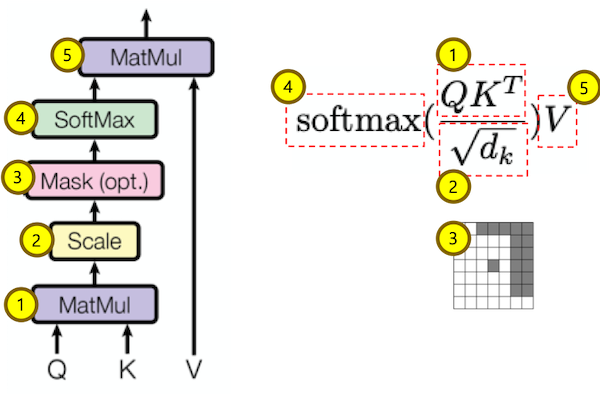
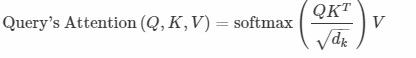

In [129]:
input_sums

tensor([[[-1.1941,  1.4137,  3.5769,  ..., -0.0938,  0.9828, -0.2583],
         [-0.1006, -0.5842,  0.0460,  ..., -0.7753, -0.0960,  0.7085],
         [-0.7524, -0.3283,  0.4613,  ...,  1.2807, -0.3499,  2.6413],
         ...,
         [-2.3014,  1.2676,  1.5278,  ...,  3.1304,  0.1179, -0.2650],
         [ 0.7566,  0.0522, -0.8600,  ...,  1.7592,  1.1731,  0.5787],
         [ 0.7566,  0.0522, -0.8600,  ...,  1.7592,  1.1731,  0.5787]],

        [[-1.1941,  1.4137,  3.5769,  ..., -0.0938,  0.9828, -0.2583],
         [ 1.9549, -1.0466, -0.0926,  ...,  0.1063,  0.0805,  0.8502],
         [ 0.1583,  1.0726, -1.0898,  ...,  2.7193,  1.0954,  1.7274],
         ...,
         [-0.8429,  0.1810, -0.3555,  ...,  0.4737,  0.0760,  0.1883],
         [-0.2610,  1.6567, -1.5655,  ...,  1.3135, -0.0049, -1.0997],
         [-0.6855,  1.7378,  2.9740,  ...,  3.1304,  0.1181, -0.2650]]],
       grad_fn=<AddBackward0>)

In [130]:
input_sums.shape

torch.Size([2, 7, 512])

### input

In [131]:
Q = input_sums
K = input_sums
V = input_sums
#어텐션 마스크
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([2, 7, 7])
tensor([[False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True]])


In [132]:
attn_mask.size()

torch.Size([2, 7, 7])

### 1). MatMul Q * K-transpose

In [133]:
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0]) #(7,512) * (512, 7)

torch.Size([2, 7, 7])
tensor([[750.0003, 191.8162, 197.8191, 180.9676, 169.0005, 198.3109, 198.3109],
        [191.8162, 721.9417, 252.6791, 212.3687, 175.0210, 203.4479, 203.4479],
        [197.8191, 252.6791, 807.2993, 237.2225, 221.0851, 189.8278, 189.8278],
        [180.9676, 212.3687, 237.2225, 762.7609, 204.9452, 191.1447, 191.1447],
        [169.0005, 175.0210, 221.0851, 204.9452, 814.5593, 203.7241, 203.7241],
        [198.3109, 203.4479, 189.8278, 191.1447, 203.7241, 696.9390, 696.9390],
        [198.3109, 203.4479, 189.8278, 191.1447, 203.7241, 696.9391, 696.9391]],
       grad_fn=<SelectBackward>)


### 2). Scale

In [134]:
#기존의 어텐션과 다른 건 스케일! 
#값의 크기가 너무 커지지 않도록 하기 위해서, 값이 커지면 기울기 소실 문제가 발생함
d_head = 512 #Key Vector dim is 512
scores = scores.mul_(1/d_head**0.5) # 
print(scores.size())
print(scores[0])

torch.Size([2, 7, 7])
tensor([[33.1456,  8.4772,  8.7425,  7.9977,  7.4688,  8.7642,  8.7642],
        [ 8.4772, 31.9056, 11.1669,  9.3855,  7.7349,  8.9912,  8.9912],
        [ 8.7425, 11.1669, 35.6779, 10.4839,  9.7707,  8.3893,  8.3893],
        [ 7.9977,  9.3855, 10.4839, 33.7096,  9.0574,  8.4475,  8.4475],
        [ 7.4688,  7.7349,  9.7707,  9.0574, 35.9988,  9.0034,  9.0034],
        [ 8.7642,  8.9912,  8.3893,  8.4475,  9.0034, 30.8006, 30.8006],
        [ 8.7642,  8.9912,  8.3893,  8.4475,  9.0034, 30.8006, 30.8006]],
       grad_fn=<SelectBackward>)


### 3). Mask (Opt.)

In [135]:
#decoder에서 수행되는 mask
scores.masked_fill_(attn_mask, -1e9) # 토큰이 없는 문장은 Softmax 계산시 0 값을 가지게 하기 위하여 마스크! 
print(scores.size())
print(scores[0])

torch.Size([2, 7, 7])
tensor([[ 3.3146e+01,  8.4772e+00,  8.7425e+00,  7.9977e+00,  7.4688e+00,
         -1.0000e+09, -1.0000e+09],
        [ 8.4772e+00,  3.1906e+01,  1.1167e+01,  9.3855e+00,  7.7349e+00,
         -1.0000e+09, -1.0000e+09],
        [ 8.7425e+00,  1.1167e+01,  3.5678e+01,  1.0484e+01,  9.7707e+00,
         -1.0000e+09, -1.0000e+09],
        [ 7.9977e+00,  9.3855e+00,  1.0484e+01,  3.3710e+01,  9.0574e+00,
         -1.0000e+09, -1.0000e+09],
        [ 7.4688e+00,  7.7349e+00,  9.7707e+00,  9.0574e+00,  3.5999e+01,
         -1.0000e+09, -1.0000e+09],
        [ 8.7642e+00,  8.9912e+00,  8.3893e+00,  8.4475e+00,  9.0034e+00,
         -1.0000e+09, -1.0000e+09],
        [ 8.7642e+00,  8.9912e+00,  8.3893e+00,  8.4475e+00,  9.0034e+00,
         -1.0000e+09, -1.0000e+09]], grad_fn=<SelectBackward>)


### 4). Softmax

In [136]:
#attention socre 
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

torch.Size([2, 7, 7])
tensor([[1.0000e+00, 1.9347e-11, 2.5225e-11, 1.1978e-11, 7.0584e-12, 0.0000e+00,
         0.0000e+00],
        [6.6858e-11, 1.0000e+00, 9.8471e-10, 1.6581e-10, 3.1827e-11, 0.0000e+00,
         0.0000e+00],
        [2.0048e-12, 2.2647e-11, 1.0000e+00, 1.1438e-11, 5.6056e-12, 0.0000e+00,
         0.0000e+00],
        [6.8151e-12, 2.7300e-11, 8.1883e-11, 1.0000e+00, 1.9665e-11, 0.0000e+00,
         0.0000e+00],
        [4.0701e-13, 5.3108e-13, 4.0670e-12, 1.9930e-12, 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0239e-01, 2.5397e-01, 1.3911e-01, 1.4745e-01, 2.5709e-01, 0.0000e+00,
         0.0000e+00],
        [2.0239e-01, 2.5397e-01, 1.3911e-01, 1.4745e-01, 2.5709e-01, 0.0000e+00,
         0.0000e+00]], grad_fn=<SelectBackward>)


### 5). MatMul Attn_prob with V

In [137]:
context = torch.matmul(attn_prob, V) #(7, 7) * (7, 512)  
print(attn_prob.size())
print(V.size())
print(context.size())
print(context[0])

torch.Size([2, 7, 7])
torch.Size([2, 7, 512])
torch.Size([2, 7, 512])
tensor([[-1.1941,  1.4137,  3.5769,  ..., -0.0938,  0.9828, -0.2583],
        [-0.1006, -0.5842,  0.0460,  ..., -0.7753, -0.0960,  0.7085],
        [-0.7524, -0.3283,  0.4613,  ...,  1.2807, -0.3499,  2.6413],
        ...,
        [-2.3014,  1.2676,  1.5278,  ...,  3.1304,  0.1179, -0.2650],
        [-1.2192,  0.1864,  0.9540,  ...,  0.9481,  0.1263,  0.5400],
        [-1.2192,  0.1864,  0.9540,  ...,  0.9481,  0.1263,  0.5400]],
       grad_fn=<SelectBackward>)


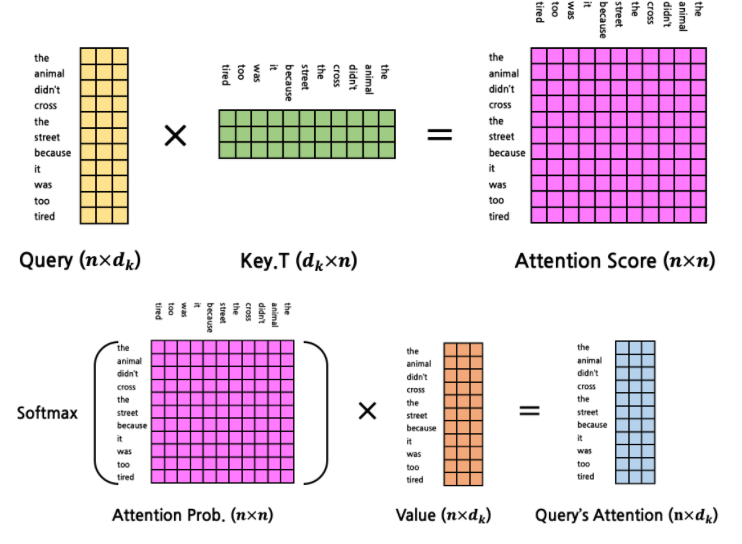
## 셀프 어텐션에서 중요한건, 입력의 사이즈와 출력의 사이즈가 같다는 것이다.

In [138]:
#한번에
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

## 3. Multi-Head Attention
![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/multi_head_attention.png)

### input

In [140]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 8
d_head= 64

### 1,2,3) input

In [141]:
W_Q = nn.Linear(d_hidn, n_head * d_head) # 512, 8*64 
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

print(W_Q)

Linear(in_features=512, out_features=512, bias=True)


In [149]:
K

tensor([[[-1.1941,  1.4137,  3.5769,  ..., -0.0938,  0.9828, -0.2583],
         [-0.1006, -0.5842,  0.0460,  ..., -0.7753, -0.0960,  0.7085],
         [-0.7524, -0.3283,  0.4613,  ...,  1.2807, -0.3499,  2.6413],
         ...,
         [-2.3014,  1.2676,  1.5278,  ...,  3.1304,  0.1179, -0.2650],
         [ 0.7566,  0.0522, -0.8600,  ...,  1.7592,  1.1731,  0.5787],
         [ 0.7566,  0.0522, -0.8600,  ...,  1.7592,  1.1731,  0.5787]],

        [[-1.1941,  1.4137,  3.5769,  ..., -0.0938,  0.9828, -0.2583],
         [ 1.9549, -1.0466, -0.0926,  ...,  0.1063,  0.0805,  0.8502],
         [ 0.1583,  1.0726, -1.0898,  ...,  2.7193,  1.0954,  1.7274],
         ...,
         [-0.8429,  0.1810, -0.3555,  ...,  0.4737,  0.0760,  0.1883],
         [-0.2610,  1.6567, -1.5655,  ...,  1.3135, -0.0049, -1.0997],
         [-0.6855,  1.7378,  2.9740,  ...,  3.1304,  0.1181, -0.2650]]],
       grad_fn=<AddBackward0>)

In [150]:
W_K(K)

tensor([[[-0.0292, -0.6137, -0.7209,  ...,  0.8984, -0.3249,  0.7359],
         [ 0.2380,  0.1245, -0.3403,  ...,  0.0057, -0.2268, -0.5225],
         [-0.6869,  1.1237, -0.5644,  ...,  0.0263, -0.2996,  0.8228],
         ...,
         [-0.7522,  0.0056,  0.4675,  ...,  1.1202, -0.4444,  0.1914],
         [-0.2139, -0.0691, -0.2094,  ...,  1.1334, -0.4763,  1.6707],
         [-0.2139, -0.0691, -0.2094,  ...,  1.1334, -0.4763,  1.6707]],

        [[-0.0292, -0.6137, -0.7209,  ...,  0.8984, -0.3249,  0.7359],
         [-0.3352,  0.6938,  0.5048,  ...,  0.1792, -0.0722,  0.1314],
         [-0.5214, -0.1561, -0.7977,  ...,  0.8466, -0.7524,  0.9612],
         ...,
         [-0.3746,  0.3391,  0.6388,  ...,  0.1292, -0.4025,  1.2210],
         [-1.5673, -0.5966,  0.3127,  ...,  1.3884, -0.3177,  1.6991],
         [-0.9918, -0.1530,  0.6735,  ...,  1.1992, -0.4322,  0.0049]]],
       grad_fn=<AddBackward0>)

In [142]:
W_Q

Linear(in_features=512, out_features=512, bias=True)

In [144]:
Q

tensor([[[-1.1941,  1.4137,  3.5769,  ..., -0.0938,  0.9828, -0.2583],
         [-0.1006, -0.5842,  0.0460,  ..., -0.7753, -0.0960,  0.7085],
         [-0.7524, -0.3283,  0.4613,  ...,  1.2807, -0.3499,  2.6413],
         ...,
         [-2.3014,  1.2676,  1.5278,  ...,  3.1304,  0.1179, -0.2650],
         [ 0.7566,  0.0522, -0.8600,  ...,  1.7592,  1.1731,  0.5787],
         [ 0.7566,  0.0522, -0.8600,  ...,  1.7592,  1.1731,  0.5787]],

        [[-1.1941,  1.4137,  3.5769,  ..., -0.0938,  0.9828, -0.2583],
         [ 1.9549, -1.0466, -0.0926,  ...,  0.1063,  0.0805,  0.8502],
         [ 0.1583,  1.0726, -1.0898,  ...,  2.7193,  1.0954,  1.7274],
         ...,
         [-0.8429,  0.1810, -0.3555,  ...,  0.4737,  0.0760,  0.1883],
         [-0.2610,  1.6567, -1.5655,  ...,  1.3135, -0.0049, -1.0997],
         [-0.6855,  1.7378,  2.9740,  ...,  3.1304,  0.1181, -0.2650]]],
       grad_fn=<AddBackward0>)

In [143]:
print(W_Q(Q))
print(W_Q(Q).size())


tensor([[[ 1.0782, -0.0440, -1.0385,  ..., -0.0774,  0.1588,  0.6512],
         [ 0.2772, -0.3754, -1.0390,  ...,  0.4709,  0.2577, -0.0240],
         [ 0.8739, -1.6306, -0.2035,  ..., -0.1315,  0.6777, -1.2185],
         ...,
         [ 0.5344, -0.3620,  0.9299,  ...,  1.2827,  0.3740, -0.3041],
         [ 0.0547,  0.1013, -0.1891,  ...,  1.0911, -0.4254,  0.1192],
         [ 0.0547,  0.1013, -0.1891,  ...,  1.0911, -0.4254,  0.1192]],

        [[ 1.0782, -0.0440, -1.0385,  ..., -0.0774,  0.1588,  0.6512],
         [ 0.9500, -0.1272, -0.5985,  ...,  0.0716, -0.0065, -0.5058],
         [-0.0100, -0.1421, -0.9502,  ...,  0.6277,  0.5610,  0.9792],
         ...,
         [ 0.9253,  0.9262, -0.0400,  ..., -0.0502, -0.9224, -0.3326],
         [-0.1454,  1.0854, -0.3589,  ..., -0.4935,  0.3988, -0.6369],
         [ 0.5344, -0.2977,  1.1551,  ...,  1.4352,  0.3145, -0.3838]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 7, 512])


In [145]:
# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)

k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)

v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 8, 7, 64]) torch.Size([2, 8, 7, 64]) torch.Size([2, 8, 7, 64])


### 4). Multi Head Attention Mask & Attention

In [146]:
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 7, 7])
torch.Size([2, 8, 7, 7])


In [147]:
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())

torch.Size([2, 8, 7, 64])


In [148]:
context

tensor([[[[ 0.2382,  0.4000, -0.2905,  ...,  0.3056, -0.4009, -0.1298],
          [ 0.3789,  0.4590, -0.1156,  ...,  0.2561, -0.3429, -0.1580],
          [ 0.4589,  0.2790, -0.1942,  ...,  0.3503, -0.5250, -0.1317],
          ...,
          [ 0.2602,  0.3340, -0.4792,  ...,  0.3345, -0.4681, -0.1805],
          [ 0.1929,  0.3993, -0.3858,  ...,  0.3013, -0.3991, -0.1185],
          [ 0.1929,  0.3993, -0.3858,  ...,  0.3013, -0.3991, -0.1185]],

         [[-0.4023, -0.3195, -0.0713,  ...,  0.1309, -0.1924, -0.2143],
          [-0.3584, -0.2649, -0.1001,  ...,  0.1200, -0.2434, -0.1970],
          [-0.2860, -0.2565,  0.0190,  ...,  0.0750, -0.2268, -0.3286],
          ...,
          [-0.2280, -0.2388,  0.1343,  ...,  0.1058, -0.1322, -0.3558],
          [-0.3536, -0.2092, -0.1586,  ...,  0.1028, -0.3850, -0.2245],
          [-0.3536, -0.2092, -0.1586,  ...,  0.1028, -0.3850, -0.2245]],

         [[-0.2276,  0.5012,  0.1242,  ..., -0.5133,  0.1533, -0.3271],
          [-0.1076,  0.5120,  

In [151]:
attn_prob # head별 att_score 

tensor([[[[0.1493, 0.2759, 0.2685, 0.1453, 0.1610, 0.0000, 0.0000],
          [0.1456, 0.1644, 0.4870, 0.0988, 0.1042, 0.0000, 0.0000],
          [0.2381, 0.1779, 0.2989, 0.1989, 0.0862, 0.0000, 0.0000],
          [0.2157, 0.2259, 0.2962, 0.1497, 0.1124, 0.0000, 0.0000],
          [0.1591, 0.1980, 0.1765, 0.1448, 0.3216, 0.0000, 0.0000],
          [0.1256, 0.2738, 0.1974, 0.1620, 0.2412, 0.0000, 0.0000],
          [0.1256, 0.2738, 0.1974, 0.1620, 0.2412, 0.0000, 0.0000]],

         [[0.1936, 0.1692, 0.2656, 0.1597, 0.2120, 0.0000, 0.0000],
          [0.1644, 0.1359, 0.3140, 0.1558, 0.2299, 0.0000, 0.0000],
          [0.1269, 0.1419, 0.2075, 0.2993, 0.2243, 0.0000, 0.0000],
          [0.0836, 0.1077, 0.2157, 0.1511, 0.4419, 0.0000, 0.0000],
          [0.1723, 0.1062, 0.1724, 0.3201, 0.2291, 0.0000, 0.0000],
          [0.1246, 0.0942, 0.3636, 0.2141, 0.2036, 0.0000, 0.0000],
          [0.1246, 0.0942, 0.3636, 0.2141, 0.2036, 0.0000, 0.0000]],

         [[0.1849, 0.1901, 0.1381, 0.2229, 0

### 5). Concat

In [152]:
# (bs, n_seq, n_head * d_head)
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)
print(context.size())

torch.Size([2, 7, 512])


### 6). Linear

In [153]:
linear = nn.Linear(n_head * d_head, d_hidn) # Linear(in_features=512, out_features=512, bias=True)
# (bs, n_seq, d_hidn)
output = linear(context)
print(output.size())### 5). Concat

torch.Size([2, 7, 512])


In [154]:
#한번에
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

## 4. Add & Norm
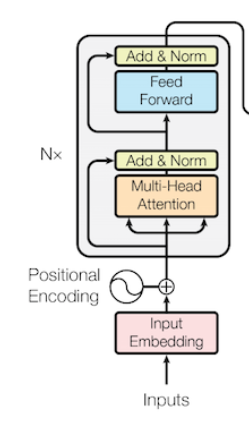

### 1). LayerNorm
#### 멀티 헤드 어텐션과 피드포워드 사이의 residual connection이 존재 
#### 역전파중 발생하는 기울기 소실을 방지

In [157]:
layer_norm1=nn.LayerNorm(512,1e-12) # dim, layer_norm_epsilon

In [158]:
norm_outputs=layer_norm1(input_sums + output)

In [159]:
norm_outputs

tensor([[[-1.5222,  1.0624,  2.6994,  ..., -0.5136,  0.2551, -1.0137],
         [-0.4573, -0.7844, -0.4909,  ..., -1.1882, -0.7374, -0.1860],
         [-0.9755, -0.4337, -0.0219,  ...,  0.7031, -0.8021,  1.5199],
         ...,
         [-2.2138,  0.9616,  0.8483,  ...,  2.2873, -0.2612, -0.8768],
         [ 0.3907, -0.0916, -1.1587,  ...,  1.2427,  0.5157, -0.1419],
         [ 0.3907, -0.0916, -1.1587,  ...,  1.2427,  0.5157, -0.1419]],

        [[-1.4506,  0.9874,  2.6735,  ..., -0.3612,  0.2899, -0.9979],
         [ 1.2513, -1.2000, -0.6069,  ..., -0.1776, -0.4865,  0.0501],
         [-0.1766,  0.5972, -1.3191,  ...,  1.9312,  0.3861,  0.6939],
         ...,
         [-1.0179, -0.0544, -0.7235,  ...,  0.1551, -0.4161, -0.4784],
         [-0.4215,  1.2218, -1.8239,  ...,  0.8601, -0.3939, -1.5605],
         [-0.8462,  1.1845,  2.0442,  ...,  2.3371, -0.3186, -0.7843]]],
       grad_fn=<NativeLayerNormBackward>)

## 5. FFNN
![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/feed-forward.png)

### 1). Linear(size up embedding dim) 

In [160]:
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
ff_1 = conv1(norm_outputs.transpose(1, 2))
print(ff_1.size())

torch.Size([2, 2048, 7])


### 2). Activation(relu of Gelu)

In [161]:
# active = F.relu
active = F.gelu
ff_2 = active(ff_1)
print(ff_2)

tensor([[[ 0.1304, -0.0479, -0.0156,  ...,  0.4000, -0.0823, -0.0823],
         [ 0.0771,  0.7127, -0.1699,  ..., -0.1052, -0.1452, -0.1452],
         [ 0.4584,  0.0867,  0.1779,  ..., -0.1632,  0.9137,  0.9137],
         ...,
         [-0.0011, -0.1300, -0.1604,  ...,  0.6058,  0.1198,  0.1198],
         [ 0.0469, -0.1693, -0.0255,  ...,  0.0427, -0.0087, -0.0087],
         [-0.1304, -0.1535, -0.1516,  ..., -0.1215, -0.0571, -0.0571]],

        [[ 0.1776,  0.1537,  0.1048,  ...,  0.5156,  0.0593,  0.5327],
         [-0.0039,  1.0161,  0.1218,  ...,  0.0929, -0.1305, -0.1009],
         [ 0.3530, -0.1467,  0.2062,  ..., -0.0730,  0.8276, -0.1538],
         ...,
         [-0.0056, -0.1597,  0.3799,  ..., -0.1524,  0.2287,  0.6172],
         [ 0.0730, -0.1699,  0.2762,  ...,  0.0146, -0.1035, -0.0066],
         [-0.1422, -0.1461, -0.1289,  ...,  0.6504, -0.1360, -0.1033]]],
       grad_fn=<GeluBackward>)


### 3). Linear(Size down)

In [162]:
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

torch.Size([2, 7, 512])


In [163]:
ff_3

tensor([[[ 1.2345e-01,  2.0763e-01, -7.1586e-02,  ...,  3.8862e-01,
          -2.6011e-01, -1.0021e-02],
         [ 2.6871e-01, -1.3120e-01, -7.2871e-02,  ...,  4.0196e-03,
          -2.7998e-01,  3.0868e-02],
         [ 1.9070e-01,  2.0951e-01, -5.7928e-02,  ...,  1.1330e-01,
           1.0383e-01, -6.1224e-01],
         ...,
         [-3.2968e-01,  4.1721e-01, -3.7434e-03,  ..., -1.2945e-01,
           1.0821e-01, -3.4947e-01],
         [ 2.9885e-01, -9.2297e-02, -3.9967e-02,  ...,  5.7536e-03,
          -4.3646e-01, -1.0538e-01],
         [ 2.9885e-01, -9.2297e-02, -3.9967e-02,  ...,  5.7537e-03,
          -4.3646e-01, -1.0538e-01]],

        [[ 1.3216e-01,  2.1628e-01, -3.5005e-02,  ...,  3.8200e-01,
          -2.6897e-01, -7.8927e-02],
         [-4.0972e-01,  5.5696e-03,  1.6758e-01,  ..., -1.3990e-02,
           3.3506e-01, -2.6905e-01],
         [ 2.4409e-01, -2.6205e-02,  1.3121e-01,  ...,  3.5187e-04,
          -2.6943e-02, -1.7145e-01],
         ...,
         [ 1.2075e-01,  2

## 5. Add & Norm with FFNN
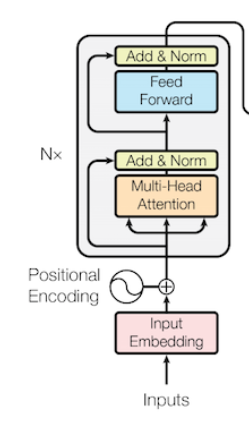

### 1). LayerNorm

In [164]:
layer_norm2=nn.LayerNorm(512,1e-12) # dim, layer_norm_epsilon

In [165]:
encoder_outputs=layer_norm2(norm_outputs + ff_3)

In [166]:
print(encoder_outputs.size())
print(encoder_outputs)

torch.Size([2, 7, 512])
tensor([[[-1.3842e+00,  1.2682e+00,  2.6178e+00,  ..., -1.1828e-01,
           9.8334e-04, -1.0115e+00],
         [-1.7481e-01, -8.8013e-01, -5.3879e-01,  ..., -1.1406e+00,
          -9.7883e-01, -1.4240e-01],
         [-7.4987e-01, -2.0049e-01, -5.9009e-02,  ...,  8.1912e-01,
          -6.6505e-01,  9.0855e-01],
         ...,
         [-2.5096e+00,  1.3350e+00,  8.1129e-01,  ...,  2.0985e+00,
          -1.6646e-01, -1.2185e+00],
         [ 6.6980e-01, -1.9227e-01, -1.1937e+00,  ...,  1.2213e+00,
           6.7497e-02, -2.5482e-01],
         [ 6.6980e-01, -1.9227e-01, -1.1937e+00,  ...,  1.2213e+00,
           6.7497e-02, -2.5482e-01]],

        [[-1.3043e+00,  1.2031e+00,  2.6295e+00,  ...,  2.7077e-02,
           2.7210e-02, -1.0641e+00],
         [ 8.3021e-01, -1.1569e+00, -4.2001e-01,  ..., -1.7817e-01,
          -1.3900e-01, -2.0492e-01],
         [ 7.5489e-02,  5.7278e-01, -1.1644e+00,  ...,  1.9167e+00,
           3.6359e-01,  5.2489e-01],
         ...,
 

In [168]:
encoder_outputs[0][0]

tensor([-1.3842e+00,  1.2682e+00,  2.6178e+00, -1.4461e-01,  6.0878e-01,
         4.9385e-01, -1.1542e-01,  7.5927e-01,  1.1266e+00, -9.7670e-01,
        -3.5544e-01,  6.1278e-01,  1.5326e-02,  1.7296e-01,  9.7854e-01,
         1.9620e-01,  6.2347e-01, -9.1298e-02,  2.8950e-01,  1.7709e+00,
         4.9860e-01,  8.2177e-01, -2.1988e+00, -3.2748e-02,  4.7596e-02,
        -4.5701e-01,  4.5842e-01, -7.5417e-01,  1.3448e-01, -3.2281e-01,
        -3.1730e-01,  6.1043e-01,  2.4324e-01, -3.8957e-01,  1.7483e+00,
         1.3562e+00,  4.0982e-01,  7.0596e-01, -5.4116e-01,  3.2368e-01,
        -8.2445e-01, -5.7576e-01, -5.3237e-01, -2.0643e-01, -1.1708e+00,
         1.8348e-01, -2.0131e+00,  1.8202e+00, -1.2246e+00, -5.3384e-01,
         4.0001e-02, -1.6990e-02, -4.9345e-01,  2.0364e+00, -5.9156e-02,
        -2.9196e-01, -2.9819e-02,  1.0936e+00, -2.0145e+00,  1.2479e-01,
        -1.0568e+00, -1.3963e+00,  3.6617e-01, -2.4804e-01,  1.8540e-01,
         4.5399e-01, -1.1115e+00,  8.4262e-01,  5.5

# DECODER

## 1. Vocab 및 Decoder 입력

In [174]:
# 타겟 texts

target_lines = [
  "겨울 날씨 위험해",
  "감기 걸리면 아파"
]

# text를 tensor로 변환
target_inputs = []
for line in target_lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    target_inputs.append(torch.tensor(ids))
    print(pieces)

# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
target_inputs = torch.nn.utils.rnn.pad_sequence(target_inputs, batch_first=True, padding_value=0)
# shape
print(target_inputs.size())
# 값
print(target_inputs)

['▁겨울', '▁날', '씨', '▁위험', '해']
['▁감', '기', '▁걸', '리', '면', '▁아', '파']
torch.Size([2, 7])
tensor([[3091,  683, 4014, 2489, 3636,    0,    0],
        [ 212, 3605,  571, 3614, 3693,   26, 3757]])


In [175]:
n_vocab = len(vocab) # vocab count
d_hidn = 512 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding 객체

target_input_embs = nn_emb(target_inputs) # input embedding
print(target_input_embs.size())

torch.Size([2, 7, 512])


In [176]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(target_inputs.size(1), device=target_inputs.device, dtype=target_inputs.dtype).expand(target_inputs.size(0), target_inputs.size(1)).contiguous() + 1
pos_mask = target_inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print(target_inputs)#입력 문장
print(positions)# 입력 문장에 대한 위치 정보
print(pos_embs.size())# 포지션 임베딩 사이즈

tensor([[3091,  683, 4014, 2489, 3636,    0,    0],
        [ 212, 3605,  571, 3614, 3693,   26, 3757]])
tensor([[1, 2, 3, 4, 5, 0, 0],
        [1, 2, 3, 4, 5, 6, 7]])
torch.Size([2, 7, 512])


In [172]:
target_input_sums = target_input_embs + pos_embs

In [173]:
target_input_sums

tensor([[[ 1.6705, -0.5348,  2.8993,  ..., -1.3655,  0.3234, -0.1254],
         [ 1.3824, -1.3194, -0.3630,  ...,  2.2014,  0.1346, -0.3328],
         [ 0.9191,  1.2774, -0.3399,  ...,  1.8012, -0.8672, -0.1725],
         ...,
         [-1.1272,  0.9004,  0.2896,  ...,  2.4690,  0.3064,  0.7866],
         [-1.5072,  1.1276, -0.9388,  ..., -2.0793,  0.1101,  2.8091],
         [-1.5072,  1.1276, -0.9388,  ..., -2.0793,  0.1101,  2.8091]],

        [[ 0.6995,  2.2767,  1.8341,  ...,  2.5571, -1.4144,  1.0373],
         [-0.3101,  1.4231, -0.5138,  ...,  1.1791, -0.8183,  1.1165],
         [ 2.0037,  0.2319, -2.1786,  ..., -0.0634,  1.3567,  0.4707],
         ...,
         [-0.2463, -1.3443, -0.9341,  ...,  0.4093, -0.3581,  1.5552],
         [ 1.5202,  1.0522, -1.6982,  ...,  1.2742,  0.3351, -0.7615],
         [ 0.4774, -0.2763,  0.2679,  ...,  1.5896, -0.9631,  1.6329]]],
       grad_fn=<AddBackward0>)

## 2. Masked Multi Head Attention
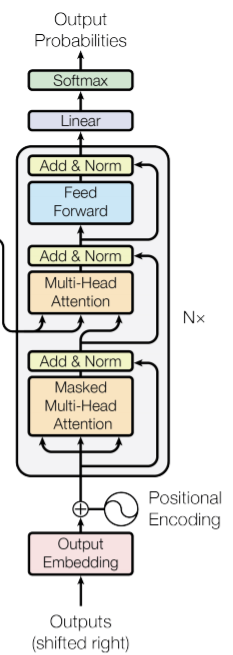

### 1) input Decoder with Subsequent_mask

In [177]:
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


Q = target_input_sums
K = target_input_sums
V = target_input_sums 
print(Q.size())

torch.Size([2, 7, 512])


In [178]:
t_attn_pad_mask = target_inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
t_attn_dec_mask = get_attn_decoder_mask(target_inputs)
print(t_attn_dec_mask[0])
t_attn_mask = torch.gt((t_attn_pad_mask + t_attn_dec_mask), 0)
print(t_attn_mask[0])

tensor([[0, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0]])
tensor([[False,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True]])


### 2) 내부동작 확인

In [179]:
Q = target_input_sums
K = target_input_sums
V = target_input_sums

print(t_attn_mask.size())
print(t_attn_mask[0]) 

torch.Size([2, 7, 7])
tensor([[False,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True]])


In [180]:
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0]) #(7,512) * (512, 7)

torch.Size([2, 7, 7])
tensor([[783.2358, 301.5289, 225.5872, 293.2358, 245.1029, 262.2879, 262.2879],
        [301.5289, 879.4860, 216.6049, 291.8235, 199.6258, 248.4342, 248.4342],
        [225.5872, 216.6049, 711.4072, 236.2227, 184.8623, 212.2263, 212.2263],
        [293.2358, 291.8235, 236.2227, 856.1794, 286.3183, 233.5882, 233.5882],
        [245.1029, 199.6258, 184.8623, 286.3183, 725.3450, 199.2267, 199.2267],
        [262.2879, 248.4342, 212.2263, 233.5882, 199.2267, 746.5200, 746.5200],
        [262.2879, 248.4342, 212.2263, 233.5882, 199.2267, 746.5200, 746.5200]],
       grad_fn=<SelectBackward>)


In [181]:
d_head = 512 
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0])

torch.Size([2, 7, 7])
tensor([[34.6145, 13.3258,  9.9696, 12.9593, 10.8321, 11.5916, 11.5916],
        [13.3258, 38.8682,  9.5727, 12.8969,  8.8223, 10.9793, 10.9793],
        [ 9.9696,  9.5727, 31.4401, 10.4397,  8.1698,  9.3792,  9.3792],
        [12.9593, 12.8969, 10.4397, 37.8381, 12.6536, 10.3232, 10.3232],
        [10.8321,  8.8223,  8.1698, 12.6536, 32.0560,  8.8047,  8.8047],
        [11.5916, 10.9793,  9.3792, 10.3232,  8.8047, 32.9918, 32.9918],
        [11.5916, 10.9793,  9.3792, 10.3232,  8.8047, 32.9918, 32.9918]],
       grad_fn=<SelectBackward>)


In [182]:
#decoder에서 수행되는 mask
scores.masked_fill_(t_attn_mask, -1e9) # t_attn_mask에 따라 대각선으로 마스킹이 수행된다.
print(scores.size())
print(scores[0])

torch.Size([2, 7, 7])
tensor([[ 3.4614e+01, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 1.3326e+01,  3.8868e+01, -1.0000e+09, -1.0000e+09, -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 9.9696e+00,  9.5727e+00,  3.1440e+01, -1.0000e+09, -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 1.2959e+01,  1.2897e+01,  1.0440e+01,  3.7838e+01, -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 1.0832e+01,  8.8223e+00,  8.1698e+00,  1.2654e+01,  3.2056e+01,
         -1.0000e+09, -1.0000e+09],
        [ 1.1592e+01,  1.0979e+01,  9.3792e+00,  1.0323e+01,  8.8047e+00,
         -1.0000e+09, -1.0000e+09],
        [ 1.1592e+01,  1.0979e+01,  9.3792e+00,  1.0323e+01,  8.8047e+00,
         -1.0000e+09, -1.0000e+09]], grad_fn=<SelectBackward>)


In [183]:
t_attn_prob = nn.Softmax(dim=-1)(scores)
print(t_attn_prob.size())
print(t_attn_prob[0])

torch.Size([2, 7, 7])
tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.0743e-12, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.7371e-10, 3.1851e-10, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.5677e-11, 1.4728e-11, 1.2618e-12, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0614e-10, 8.1231e-11, 4.2302e-11, 3.7466e-09, 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.0139e-01, 2.7182e-01, 5.4869e-02, 1.4104e-01, 3.0890e-02, 0.0000e+00,
         0.0000e+00],
        [5.0139e-01, 2.7182e-01, 5.4869e-02, 1.4104e-01, 3.0890e-02, 0.0000e+00,
         0.0000e+00]], grad_fn=<SelectBackward>)


In [184]:
t_context = torch.matmul(t_attn_prob, V) #(7, 7) * (7, 512)  
print(t_attn_prob.size())
print(V.size())
print(t_context.size())
print(t_context[0])

torch.Size([2, 7, 7])
torch.Size([2, 7, 512])
torch.Size([2, 7, 512])
tensor([[ 1.6705, -0.5348,  2.8993,  ..., -1.3655,  0.3234, -0.1254],
        [ 1.3824, -1.3194, -0.3630,  ...,  2.2014,  0.1346, -0.3328],
        [ 0.9191,  1.2774, -0.3399,  ...,  1.8012, -0.8672, -0.1725],
        ...,
        [-1.1272,  0.9004,  0.2896,  ...,  2.4690,  0.3064,  0.7866],
        [ 1.1807, -0.7789,  1.0468,  ..., -0.0815,  0.0143,  0.1898],
        [ 1.1807, -0.7789,  1.0468,  ..., -0.0815,  0.0143,  0.1898]],
       grad_fn=<SelectBackward>)


### 3) masked multi head Attention 


In [185]:

t_attention = MultiHeadAttention(d_hidn, n_head, d_head)
t_output, t_attn_prob = t_attention(Q, K, V, t_attn_mask)
print(t_output.size(), t_attn_prob.size())

torch.Size([2, 7, 512]) torch.Size([2, 8, 7, 7])


In [186]:
t_attn_prob

tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.3568, 0.6432, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2392, 0.4321, 0.3287, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.1885, 0.2775, 0.3127, 0.2212, 0.0000, 0.0000, 0.0000],
          [0.1917, 0.1959, 0.2771, 0.1764, 0.1589, 0.0000, 0.0000],
          [0.1680, 0.1665, 0.2717, 0.1672, 0.2265, 0.0000, 0.0000],
          [0.1680, 0.1665, 0.2717, 0.1672, 0.2265, 0.0000, 0.0000]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5353, 0.4647, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.3615, 0.3365, 0.3020, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2936, 0.1730, 0.2002, 0.3331, 0.0000, 0.0000, 0.0000],
          [0.1868, 0.2278, 0.2249, 0.0739, 0.2866, 0.0000, 0.0000],
          [0.1735, 0.1222, 0.2215, 0.2173, 0.2655, 0.0000, 0.0000],
          [0.1735, 0.1222, 0.2215, 0.2173, 0.2655, 0.0000, 0.0000]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0

## 3. Add & Norm DECODER


### 1). LayerNorm

In [187]:
layer_norm3=nn.LayerNorm(512,1e-12) # dim, layer_norm_epsilon

In [188]:
t_norm_outputs=layer_norm3(target_input_sums + t_output)

In [189]:
t_norm_outputs

tensor([[[ 1.1829, -0.4533,  1.7568,  ..., -1.9891,  0.2651, -0.5273],
         [ 0.7440, -1.4759, -0.9504,  ...,  1.1027, -0.0589, -0.9034],
         [ 0.5855,  0.9967, -0.9051,  ...,  1.0706, -0.9449, -0.6993],
         ...,
         [-1.2410,  0.7083, -0.3534,  ...,  1.5560,  0.0191,  0.1951],
         [-1.6291,  0.8851, -1.4625,  ..., -2.3928, -0.2020,  1.9570],
         [-1.6291,  0.8851, -1.4625,  ..., -2.3928, -0.2020,  1.9570]],

        [[-0.0248,  1.2894,  0.3742,  ...,  1.4713, -1.1960, -0.0762],
         [-0.8775,  0.7600, -1.4441,  ...,  0.3176, -0.7453,  0.2581],
         [ 1.4479, -0.1602, -2.5071,  ..., -0.5132,  0.9221, -0.1171],
         ...,
         [-0.3491, -1.3518, -1.3414,  ..., -0.2361, -0.5529,  0.8325],
         [ 1.2346,  0.6356, -1.9180,  ...,  0.5369,  0.0094, -1.1757],
         [ 0.2245, -0.5181, -0.4376,  ...,  0.8510, -1.2109,  0.6739]]],
       grad_fn=<NativeLayerNormBackward>)

## 4. Encoder-Decoder Multi- Head Attention
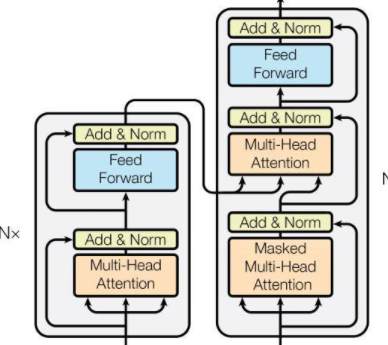


### 1) input Decoder --> Q, Encoder--> K, V, and Encoder attn_mask

In [190]:
Q = t_norm_outputs
print("Q {}".format(Q.size()))
K = encoder_outputs
print("K {}".format(K.size()))
V = encoder_outputs
print("V {}".format(V.size()))

attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0]) 

Q torch.Size([2, 7, 512])
K torch.Size([2, 7, 512])
V torch.Size([2, 7, 512])
torch.Size([2, 7, 7])
tensor([[False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True]])


### 2) Encoder-Decoder attention

In [191]:
e_d_attention = MultiHeadAttention(d_hidn, n_head, d_head)
e_d_output, e_d_attn_prob = e_d_attention(Q, K, V, attn_mask)
print(e_d_output.size(), e_d_attn_prob.size())

torch.Size([2, 7, 512]) torch.Size([2, 8, 7, 7])


In [192]:
e_d_attn_prob[0]

tensor([[[0.3547, 0.1012, 0.2169, 0.1631, 0.1641, 0.0000, 0.0000],
         [0.3637, 0.1744, 0.1849, 0.1685, 0.1084, 0.0000, 0.0000],
         [0.3361, 0.1564, 0.1951, 0.1742, 0.1382, 0.0000, 0.0000],
         [0.2115, 0.2647, 0.1968, 0.1956, 0.1314, 0.0000, 0.0000],
         [0.2233, 0.1199, 0.1666, 0.2185, 0.2716, 0.0000, 0.0000],
         [0.2453, 0.1731, 0.2217, 0.1297, 0.2302, 0.0000, 0.0000],
         [0.2453, 0.1731, 0.2217, 0.1297, 0.2302, 0.0000, 0.0000]],

        [[0.1585, 0.2335, 0.2726, 0.1763, 0.1591, 0.0000, 0.0000],
         [0.1330, 0.2771, 0.2730, 0.1451, 0.1718, 0.0000, 0.0000],
         [0.1924, 0.2373, 0.2092, 0.2137, 0.1474, 0.0000, 0.0000],
         [0.1548, 0.2871, 0.1821, 0.1809, 0.1951, 0.0000, 0.0000],
         [0.1743, 0.2646, 0.1575, 0.2300, 0.1735, 0.0000, 0.0000],
         [0.1917, 0.2552, 0.1399, 0.2198, 0.1933, 0.0000, 0.0000],
         [0.1917, 0.2552, 0.1399, 0.2198, 0.1933, 0.0000, 0.0000]],

        [[0.2666, 0.2169, 0.1365, 0.2094, 0.1707, 0.0000, 

## 5. Add & Norm ENCODER-DECODER


### 1). LayerNorm

In [193]:
layer_norm4=nn.LayerNorm(512,1e-12) # dim, layer_norm_epsilon

In [194]:
e_d_norm_outputs=layer_norm4(t_norm_outputs + e_d_output)

In [195]:
e_d_norm_outputs

tensor([[[ 9.3461e-01, -7.2758e-01,  1.7098e+00,  ..., -2.1215e+00,
           1.8254e-01, -7.4643e-01],
         [ 5.0955e-01, -1.7809e+00, -9.5419e-01,  ...,  9.0909e-01,
          -1.6891e-01, -1.0624e+00],
         [ 3.2961e-01,  6.5531e-01, -9.0314e-01,  ...,  8.6862e-01,
          -1.0553e+00, -9.5015e-01],
         ...,
         [-1.4317e+00,  4.0106e-01, -3.5634e-01,  ...,  1.3758e+00,
          -9.0479e-02, -3.6671e-02],
         [-1.8476e+00,  5.6429e-01, -1.4401e+00,  ..., -2.5270e+00,
          -2.8861e-01,  1.6838e+00],
         [-1.8476e+00,  5.6429e-01, -1.4401e+00,  ..., -2.5270e+00,
          -2.8861e-01,  1.6838e+00]],

        [[-2.3144e-01,  9.7975e-01,  3.0702e-01,  ...,  1.2915e+00,
          -1.1604e+00, -1.9828e-01],
         [-1.0777e+00,  4.1555e-01, -1.5089e+00,  ...,  1.4762e-01,
          -7.5133e-01,  1.1948e-01],
         [ 1.1778e+00, -4.8919e-01, -2.5421e+00,  ..., -6.6862e-01,
           9.1349e-01, -2.5032e-01],
         ...,
         [-5.4887e-01, -1

## 6. FFNN
![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/feed-forward.png)

### 1). Linear(size up embedding dim) 

In [196]:
d_conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
d_ff_1 = conv1(e_d_norm_outputs.transpose(1, 2))
print(d_ff_1.size())

torch.Size([2, 2048, 7])


### 2). Activation(relu of Gelu)

In [197]:
# active = F.relu
active = F.gelu
d_ff_2 = active(d_ff_1)
print(d_ff_2)

tensor([[[ 0.0465,  0.2358,  0.0391,  ...,  0.0401,  0.1574,  0.1574],
         [-0.1641, -0.1524, -0.1648,  ..., -0.1693, -0.0836, -0.0836],
         [-0.1699, -0.0199,  0.1591,  ..., -0.1423, -0.1131, -0.1131],
         ...,
         [ 0.3213,  0.1051, -0.1168,  ...,  0.7968, -0.0883, -0.0883],
         [-0.1383,  0.1056,  0.8124,  ...,  0.5370,  1.1536,  1.1536],
         [-0.1254, -0.1699, -0.1476,  ...,  0.2040, -0.0567, -0.0567]],

        [[-0.0938, -0.0663,  0.5245,  ..., -0.1698,  0.7836, -0.0877],
         [-0.0151, -0.0538, -0.1599,  ..., -0.1525, -0.1523, -0.1644],
         [-0.0801, -0.1261, -0.1461,  ...,  0.7856, -0.1512,  0.2784],
         ...,
         [-0.1699, -0.1553,  0.1260,  ...,  0.5332,  0.2431,  0.6785],
         [-0.0921, -0.0236,  0.7234,  ..., -0.1480, -0.1575,  0.1233],
         [-0.1698, -0.1298, -0.1698,  ...,  0.0961, -0.1552,  0.1287]]],
       grad_fn=<GeluBackward>)


### 3). Linear(Size down)

In [198]:
d_conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
d_ff_3 = conv2(d_ff_2).transpose(1, 2)
print(d_ff_3.size())

torch.Size([2, 7, 512])


In [199]:
d_ff_3

tensor([[[-0.0971,  0.1080, -0.0962,  ..., -0.1007,  0.0670, -0.0513],
         [ 0.1034,  0.2548,  0.2842,  ..., -0.1389, -0.2132,  0.0117],
         [-0.3283, -0.0902,  0.1992,  ..., -0.0872, -0.2274, -0.3690],
         ...,
         [-0.0356,  0.0589,  0.2029,  ..., -0.1051, -0.4958, -0.3073],
         [-0.0899, -0.1088, -0.1051,  ..., -0.1234,  0.0746, -0.1835],
         [-0.0899, -0.1088, -0.1051,  ..., -0.1234,  0.0746, -0.1835]],

        [[-0.2224,  0.0148,  0.1216,  ..., -0.2463, -0.4992,  0.0513],
         [ 0.1659,  0.1941,  0.0531,  ...,  0.1205, -0.2163, -0.3309],
         [-0.4166,  0.2815,  0.0243,  ...,  0.1849, -0.4592, -0.2789],
         ...,
         [-0.2728,  0.2034,  0.0651,  ..., -0.0625, -0.2528,  0.2395],
         [-0.0523,  0.1760,  0.2853,  ...,  0.1964, -0.4661, -0.2785],
         [-0.4870, -0.0592, -0.0727,  ...,  0.0304, -0.2527, -0.1158]]],
       grad_fn=<TransposeBackward0>)

## 7. Add & Norm with FFNN

### 1). LayerNorm

In [200]:
layer_norm5=nn.LayerNorm(512,1e-12) # dim, layer_norm_epsilon

In [201]:
final_outputs=layer_norm5(t_norm_outputs + d_ff_3)

In [202]:
print(final_outputs.size())
print(final_outputs)

torch.Size([2, 7, 512])
tensor([[[ 1.0701, -0.3347,  1.6343,  ..., -2.0471,  0.3303, -0.5638],
         [ 0.8473, -1.1995, -0.6505,  ...,  0.9624, -0.2605, -0.8736],
         [ 0.2533,  0.8875, -0.6873,  ...,  0.9627, -1.1430, -1.0413],
         ...,
         [-1.2717,  0.7485, -0.1585,  ...,  1.4243, -0.4810, -0.1207],
         [-1.7016,  0.7813, -1.5509,  ..., -2.4948, -0.1179,  1.7736],
         [-1.7016,  0.7813, -1.5509,  ..., -2.4948, -0.1179,  1.7736]],

        [[-0.2441,  1.2672,  0.4797,  ...,  1.1900, -1.6546, -0.0276],
         [-0.6926,  0.9261, -1.3529,  ...,  0.4246, -0.9356, -0.0719],
         [ 1.0087,  0.1135, -2.4478,  ..., -0.3287,  0.4496, -0.3953],
         ...,
         [-0.6264, -1.1440, -1.2697,  ..., -0.3086, -0.8071,  1.0389],
         [ 1.1528,  0.7940, -1.5720,  ...,  0.7182, -0.4336, -1.3992],
         [-0.2651, -0.5707, -0.5056,  ...,  0.8456, -1.4312,  0.5317]]],
       grad_fn=<NativeLayerNormBackward>)


In [207]:
final_outputs[0][0]

tensor([ 1.0701e+00, -3.3472e-01,  1.6343e+00, -1.9292e+00,  4.4069e-01,
         5.7144e-01, -9.7247e-01,  1.1432e+00,  4.2897e-01, -2.4742e-01,
         6.2483e-01,  2.4475e-01,  2.5185e-01, -8.5335e-01, -2.6304e-01,
        -1.2194e-01, -9.8448e-01, -1.4311e+00,  1.9191e+00, -5.9229e-02,
        -1.5051e-01,  1.2598e+00, -1.4413e+00,  1.3573e-01, -1.4436e+00,
        -5.6662e-01,  1.3544e+00, -1.2798e+00,  6.0765e-01,  4.5340e-01,
        -7.0980e-01, -7.3820e-01,  7.8520e-03, -1.3819e+00,  1.0516e+00,
         4.5203e-01,  1.5841e+00,  2.4422e+00,  2.4246e-01,  5.2198e-01,
        -9.0308e-01, -3.6238e-02, -1.0642e+00,  2.8444e-01, -6.2167e-01,
         2.4516e-01, -3.7501e-01,  7.4076e-01, -2.1236e+00,  4.6705e-01,
         8.3595e-02,  7.5039e-01,  1.1820e-01,  1.3154e+00,  1.6055e+00,
         1.3214e+00,  1.2570e+00,  3.6226e-02,  2.4681e+00,  7.5628e-01,
         4.9333e-01, -1.5539e-01,  7.1895e-01, -3.8347e-01,  8.8802e-01,
         2.0187e-01,  2.3933e-01, -5.1288e-01, -6.5

### 8. Generator and Output Probabilities
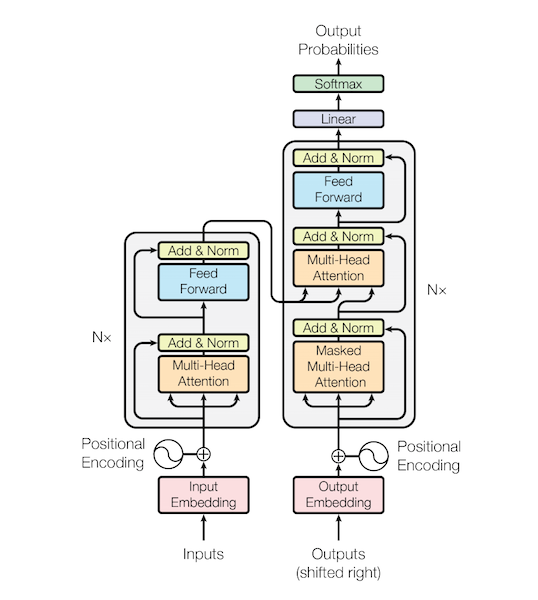

### 1) create FC_layer

In [203]:
de_fc_layer=nn.Linear(512, 8007) #dim, len(Vocab)

In [204]:
g_outs=de_fc_layer(final_outputs)

In [205]:
g_outs[0]

tensor([[-0.0204,  0.8909,  0.1992,  ...,  0.9145, -0.5686,  0.1633],
        [ 0.4963,  1.0077,  0.0119,  ..., -0.2172,  0.6060, -0.8622],
        [ 0.1640,  0.5350,  0.2315,  ..., -0.3898,  0.0547, -0.6015],
        ...,
        [ 1.0981,  0.2666, -0.1740,  ..., -0.5459,  0.1108, -0.1528],
        [ 0.2102,  0.0336, -0.0968,  ...,  0.2531,  0.2235, -0.3593],
        [ 0.2102,  0.0336, -0.0968,  ...,  0.2531,  0.2235, -0.3593]],
       grad_fn=<SelectBackward>)

In [110]:
torch.argmax(F.log_softmax(g_outs[0], dim=-1), dim=-1)

tensor([ 224, 2480, 7891, 6774, 5691,  961,  961])